# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4
import xarray as xr
from datetime import datetime
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import scipy.spatial as ss

from scipy.stats import pearsonr
from scipy import signal

import xskillscore as xs

# Atmosphere

In [3]:
taux_1989 = xr.open_dataarray('taux_1989_hum_regridded.nc')
tauy_1989 = xr.open_dataarray('tauy_1989_hum_regridded.nc')
taux_2006 = xr.open_dataarray('taux_2006_hum_regridded.nc')
tauy_2006 = xr.open_dataarray('tauy_2006_hum_regridded.nc')
taux_full = xr.open_dataarray('zw_hum_regridded.nc')
tauy_full = xr.open_dataarray('mw_hum_regridded.nc')

In [4]:
rho = 1025
omega = 7.29*10**(-5)
f = 2*omega*np.sin(np.radians(-30))
R_d = 50000 # Rossby radius of deformation

W_Ek_1989 = -tauy_1989/(rho*f) # Ekman transport (m^2/s or m^3/s per meter of coast) --> volume transport
Vert_vel_1989 = W_Ek_1989/R_d # Vertical velocity due to Ekman transport (m/s)

W_Ek_2006 = -tauy_2006/(rho*f) # Ekman transport (m^2/s or m^3/s per meter of coast) --> volume transport
Vert_vel_2006 = W_Ek_2006/R_d # Vertical velocity due to Ekman transport (m/s)

W_Ek_base = -tauy_full/(rho*f)
Vert_vel_base = W_Ek_base/R_d

In [5]:
Vert_vel_mean = Vert_vel_1989.mean('time')

In [7]:
coastal_indices = np.zeros(Vert_vel_mean.lat.size)
for i, lat in enumerate(Vert_vel_mean):
    idx = np.argwhere(lat.values==lat[~np.isnan(lat)][-1].values)
    coastal_indices[i] = idx[0,0]

Vert_vel_coastal_1989 = Vert_vel_1989.transpose('lat','lon','time')
for i, lat in enumerate(Vert_vel_coastal_1989):
    Vert_vel_coastal_1989[i] = lat.where(lat.lon == lat.lon[int(coastal_indices[i])])
    
Vert_vel_coastal_2006 = Vert_vel_2006.transpose('lat','lon','time')
for i, lat in enumerate(Vert_vel_coastal_2006):
    Vert_vel_coastal_2006[i] = lat.where(lat.lon == lat.lon[int(coastal_indices[i])])
    
Vert_vel_coastal_base = Vert_vel_base.transpose('lat','lon','time')
for i, lat in enumerate(Vert_vel_coastal_base):
    Vert_vel_coastal_base[i] = lat.where(lat.lon == lat.lon[int(coastal_indices[i])])

In [8]:
# Calculate wind stress curl

x = taux_1989.lon.values
y = taux_1989.lat.values

dx = np.cos(np.radians(-30))*111000
dy = 111000

curl_1989 = tauy_1989.differentiate('lon')/dx - taux_1989.differentiate('lat')/dy
curl_2006 = tauy_2006.differentiate('lon')/dx - taux_2006.differentiate('lat')/dy
curl_base = tauy_full.differentiate('lon')/dx - taux_full.differentiate('lat')/dy

In [9]:
Ek_pump_1989 = 1/(rho*f)*curl_1989 # Ekman pumping velocity (m/s)
Ek_pump_2006 = 1/(rho*f)*curl_2006 # Ekman pumping velocity (m/s)
Ek_pump_base = 1/(rho*f)*curl_base # Ekman pumping velocity (m/s)

In [10]:
X, Y = np.meshgrid(x, y)

In [11]:
Upwelling_1989 = Ek_pump_1989.combine_first(Vert_vel_coastal_1989)
Upwelling_2006 = Ek_pump_2006.combine_first(Vert_vel_coastal_2006)
Upwelling_base = Ek_pump_base.combine_first(Vert_vel_coastal_base)

# Advection

In [14]:
vvel_alltime = xr.open_dataarray('vvel_humboldt_regridded.nc')
uvel_alltime = xr.open_dataarray('uvel_humboldt_regridded.nc')

In [15]:
vvel_mean = vvel_alltime.mean('time').sel()
vvel_mean_spatial = vvel_mean.sel(z_t=slice(100,400)).mean('z_t')

uvel_mean = uvel_alltime.mean('time').sel()
uvel_mean_spatial = uvel_mean.sel(z_t=slice(100,400)).mean('z_t')

In [17]:
vvel_1989 = xr.open_dataarray('vvel_1989_hum_regridded.nc')
vvel_2006 = xr.open_dataarray('vvel_2006_hum_regridded.nc')

In [19]:
uvel_1989 = xr.open_dataarray('uvel_1989_hum_regridded.nc')
uvel_2006 = xr.open_dataarray('uvel_2006_hum_regridded.nc')

In [20]:
vvel_1989 = vvel_1989.groupby('time.year').mean('time')
vvel_2006 = vvel_2006.groupby('time.year').mean('time')

uvel_1989 = uvel_1989.groupby('time.year').mean('time')
uvel_2006 = uvel_2006.groupby('time.year').mean('time')

In [21]:
vvel_1989_spatial = vvel_1989[10:].mean('year').sel(z_t=slice(100,400)).mean('z_t')
vvel_2006_spatial = vvel_2006[10:].mean('year').sel(z_t=slice(100,400)).mean('z_t')

In [22]:
uvel_1989_spatial = uvel_1989[10:].mean('year').sel(z_t=slice(100,400)).mean('z_t')
uvel_2006_spatial = uvel_2006[10:].mean('year').sel(z_t=slice(100,400)).mean('z_t')

In [23]:
vvel_1989_southward = vvel_1989[10:].where(vvel_1989.mean('year').sel(z_t=slice(100,400)).mean('z_t')<0).sel(lat=slice(-40,-15))

In [24]:
vvel_1989_southward_spatial = vvel_1989_southward.sel(z_t=slice(100, 400)).mean(dim=('year','z_t'))

In [25]:
vvel_2006_southward = vvel_2006[10:].where(vvel_2006.mean('year').sel(z_t=slice(100,400)).mean('z_t')<0).sel(lat=slice(-40,-15))

In [26]:
vvel_2006_southward_spatial = vvel_2006_southward.sel(z_t=slice(100, 400)).mean(dim=('year','z_t'))

# Oxygen

In [30]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [31]:
humboldt_O2min_1989 = xr.open_dataarray('O2min1989_humboldt_regridded.nc')
humboldt_O2min_2006 = xr.open_dataarray('O2min2006_humboldt_regridded.nc')

humboldt_O2min_1989 = weighted_temporal_mean(humboldt_O2min_1989)
humboldt_O2min_2006 = weighted_temporal_mean(humboldt_O2min_2006)

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(


In [32]:
humboldt_O2min_1989N = humboldt_O2min_1989.sel(lat=slice(-33, -15))
humboldt_O2min_1989S = humboldt_O2min_1989.sel(lat=slice(-45, -33))

humboldt_O2min_2006N = humboldt_O2min_2006.sel(lat=slice(-33, -15))
humboldt_O2min_2006S = humboldt_O2min_2006.sel(lat=slice(-45, -33))

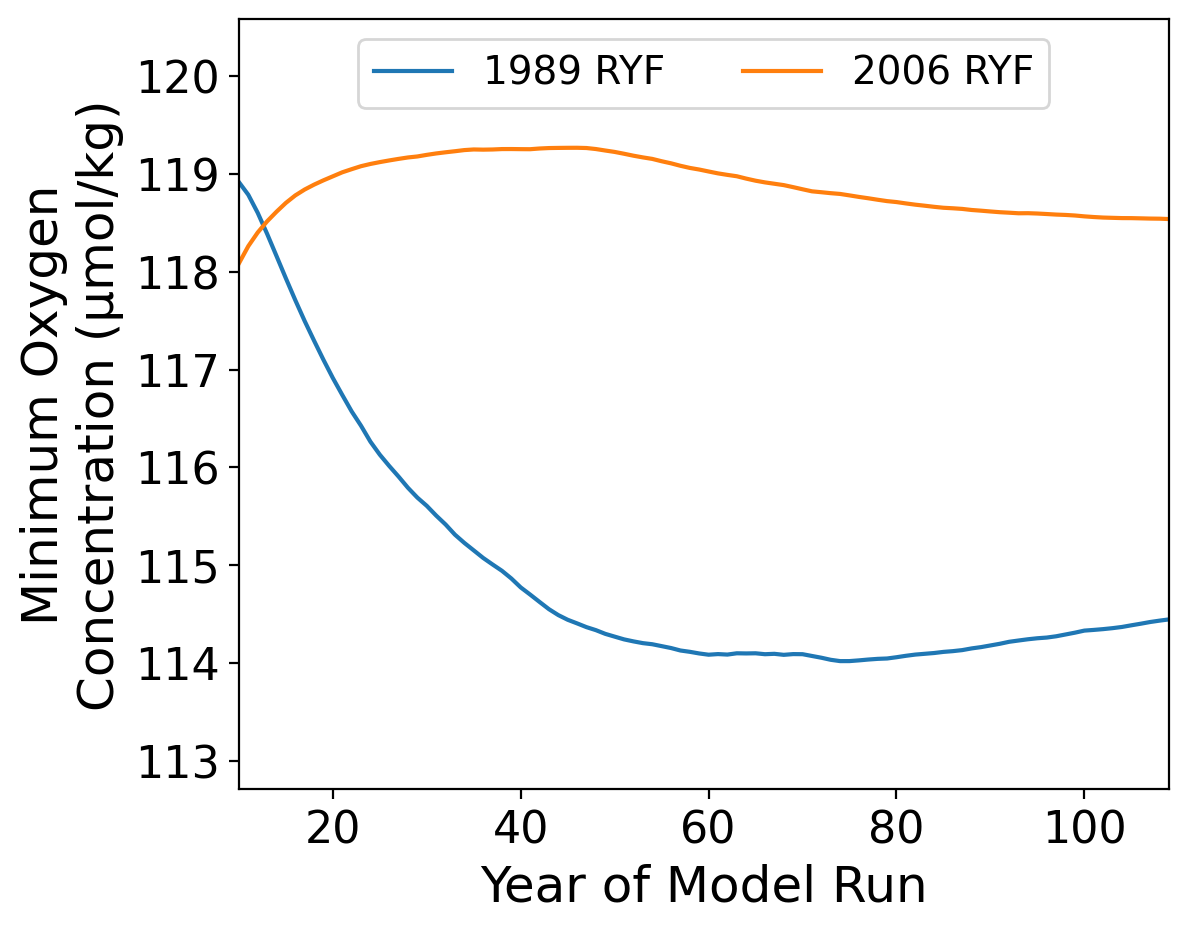

In [32]:
fig = plt.figure(figsize=(6,5), dpi=200)

y1 = humboldt_O2min_1989S.mean(dim=('lat', 'lon'))[10:]
y2 = humboldt_O2min_2006S.mean(dim=('lat', 'lon'))[10:]
x = y1['time.year']-2011

plt.plot(x, y1, label='1989 RYF')
plt.plot(x, y2, label='2006 RYF')
plt.tick_params('both', labelsize=16)
plt.margins(0, 0.25)
plt.xlabel('Year of Model Run', fontsize=18)
plt.ylabel('Minimum Oxygen\nConcentration (µmol/kg)', fontsize=18)
plt.legend(fontsize=14, ncol=2, loc='upper center')
fig.patch.set_fill(False)

plt.show()

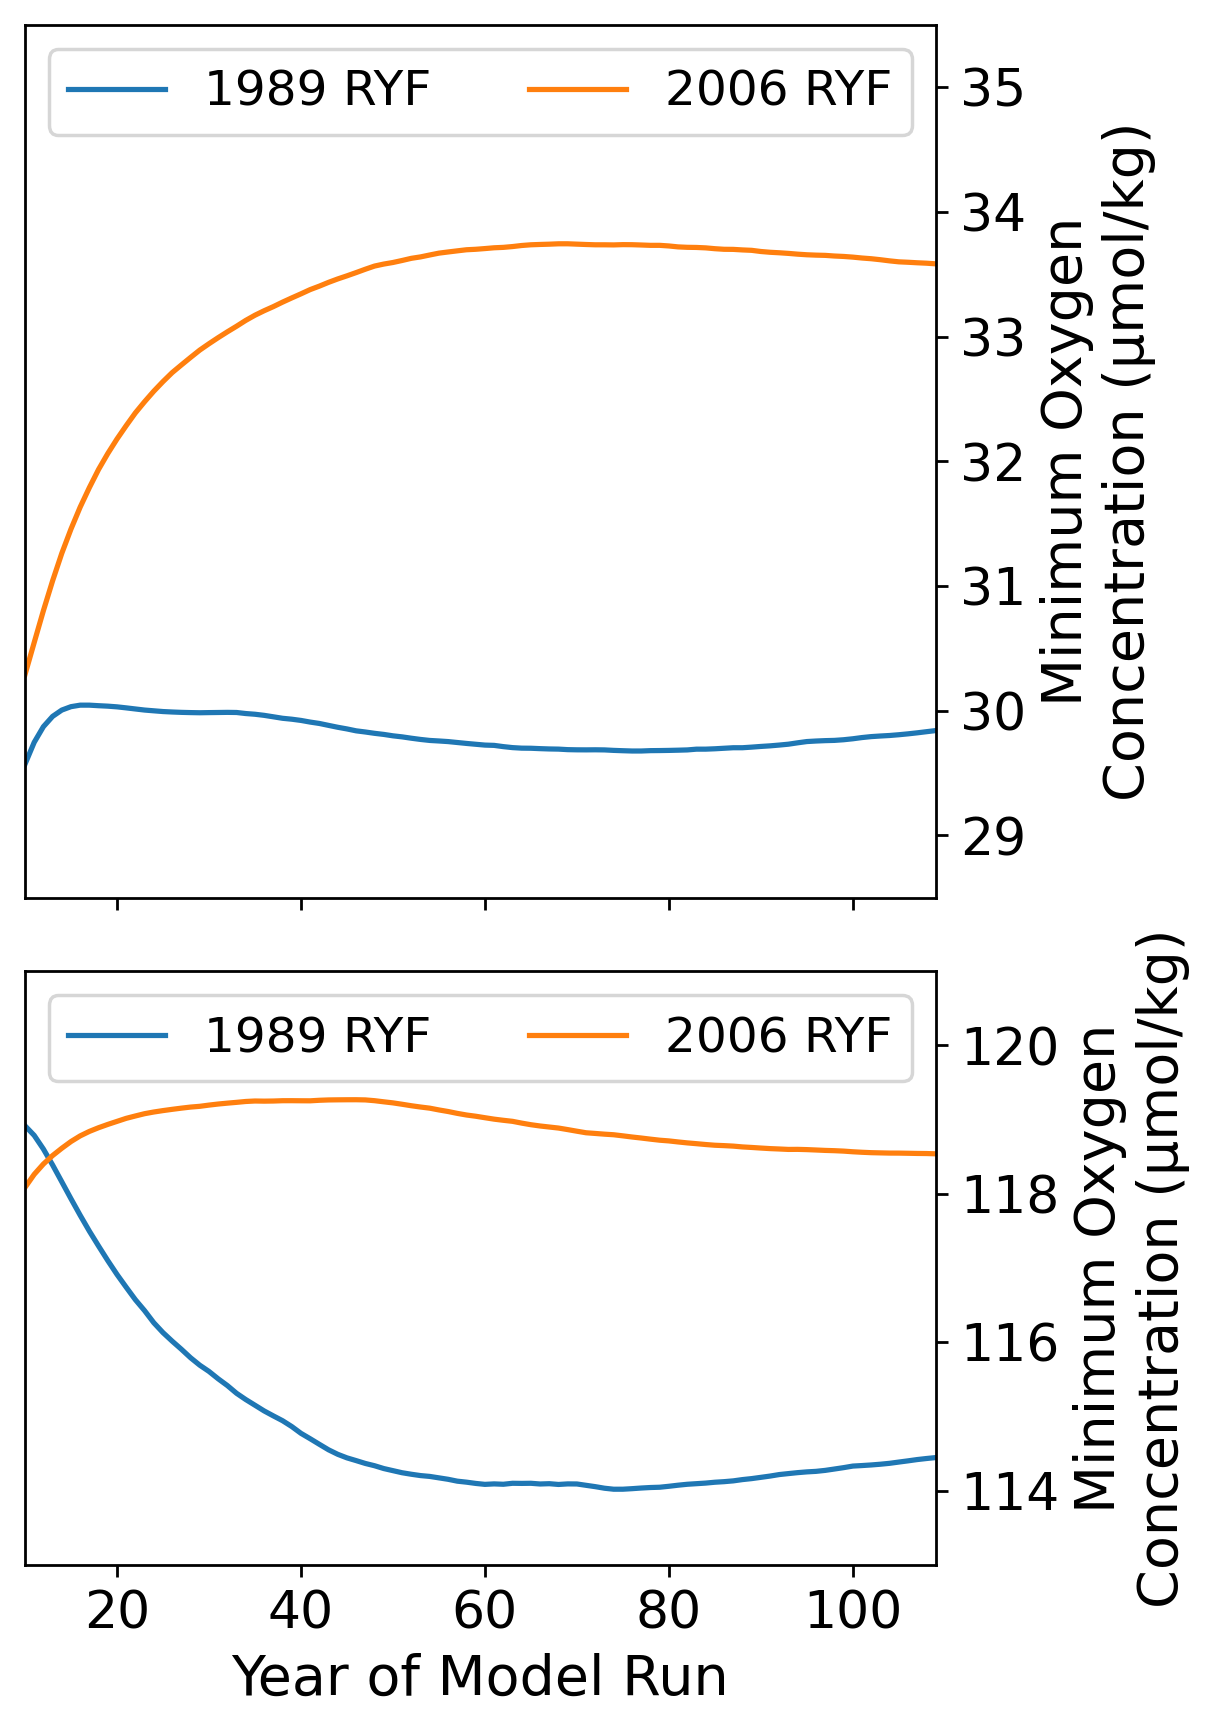

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(4.7, 8), sharex=True, gridspec_kw={'height_ratios': [1, 0.68]}, dpi=250)

y1 = humboldt_O2min_1989N.mean(dim=('lat', 'lon'))[10:]
y2 = humboldt_O2min_2006N.mean(dim=('lat', 'lon'))[10:]
x = y1['time.year']-2011

ax[0].plot(x, y1, label='1989 RYF')
ax[0].plot(x, y2, label='2006 RYF')
ax[0].tick_params('both', labelsize=15)
ax[0].margins(0, 0.25)
ax[0].set_ylabel('Minimum Oxygen\nConcentration (µmol/kg)', fontsize=16)
ax[0].legend(fontsize=14, ncol=2, loc='upper center')
ax[0].set_ylim([28.5, 35.5])
fig.patch.set_fill(False)

y1 = humboldt_O2min_1989S.mean(dim=('lat', 'lon'))[10:]
y2 = humboldt_O2min_2006S.mean(dim=('lat', 'lon'))[10:]
x = y1['time.year']-2011

ax[1].plot(x, y1, label='1989 RYF')
ax[1].plot(x, y2, label='2006 RYF')
ax[1].tick_params('both', labelsize=15)
ax[1].margins(0, 0.25)
ax[1].set_xlabel('Year of Model Run', fontsize=16)
ax[1].set_ylabel('Minimum Oxygen\nConcentration (µmol/kg)', fontsize=16)
ax[1].legend(fontsize=14, ncol=2, loc='upper center')
ax[1].set_ylim([113, 121])
fig.patch.set_fill(False)

for axis in ax:
    axis.yaxis.set_label_position("right")
    axis.yaxis.tick_right()

plt.subplots_adjust(hspace=0.1)

plt.show()

In [34]:
anomaly_1989 = tauy_1989.mean('time') - tauy_full.mean('time')
anomaly_2006 = tauy_2006.mean('time') - tauy_full.mean('time')

In [35]:
x = uvel_1989_spatial.lon
y = uvel_1989_spatial.lat
u = (uvel_2006_spatial-uvel_1989_spatial).values
v = (vvel_2006_spatial-vvel_1989_spatial).values

In [37]:
DOC_1989 = xr.open_dataarray('DOC_1989_hum_regridded.nc')
DOC_2006 = xr.open_dataarray('DOC_2006_hum_regridded.nc')
DOC_full = xr.open_dataarray('DOC_remin_hum_regridded.nc')

In [38]:
DOC_1989_spatial = DOC_1989[120:].mean('time').sum('z_t')
DOC_2006_spatial = DOC_2006[120:].mean('time').sum('z_t')
DOC_full_spatial = DOC_full.mean('time').sum('z_t')

In [39]:
DOC_1989_spatial = DOC_1989_spatial.sel(lat=slice(-45,-33))
DOC_2006_spatial = DOC_2006_spatial.sel(lat=slice(-45,-33))
DOC_full_spatial = DOC_full_spatial.sel(lat=slice(-45,-33))

In [40]:
skip = (slice(None, None, 2), slice(None, None, None)) # Skip some data points for less arrow density

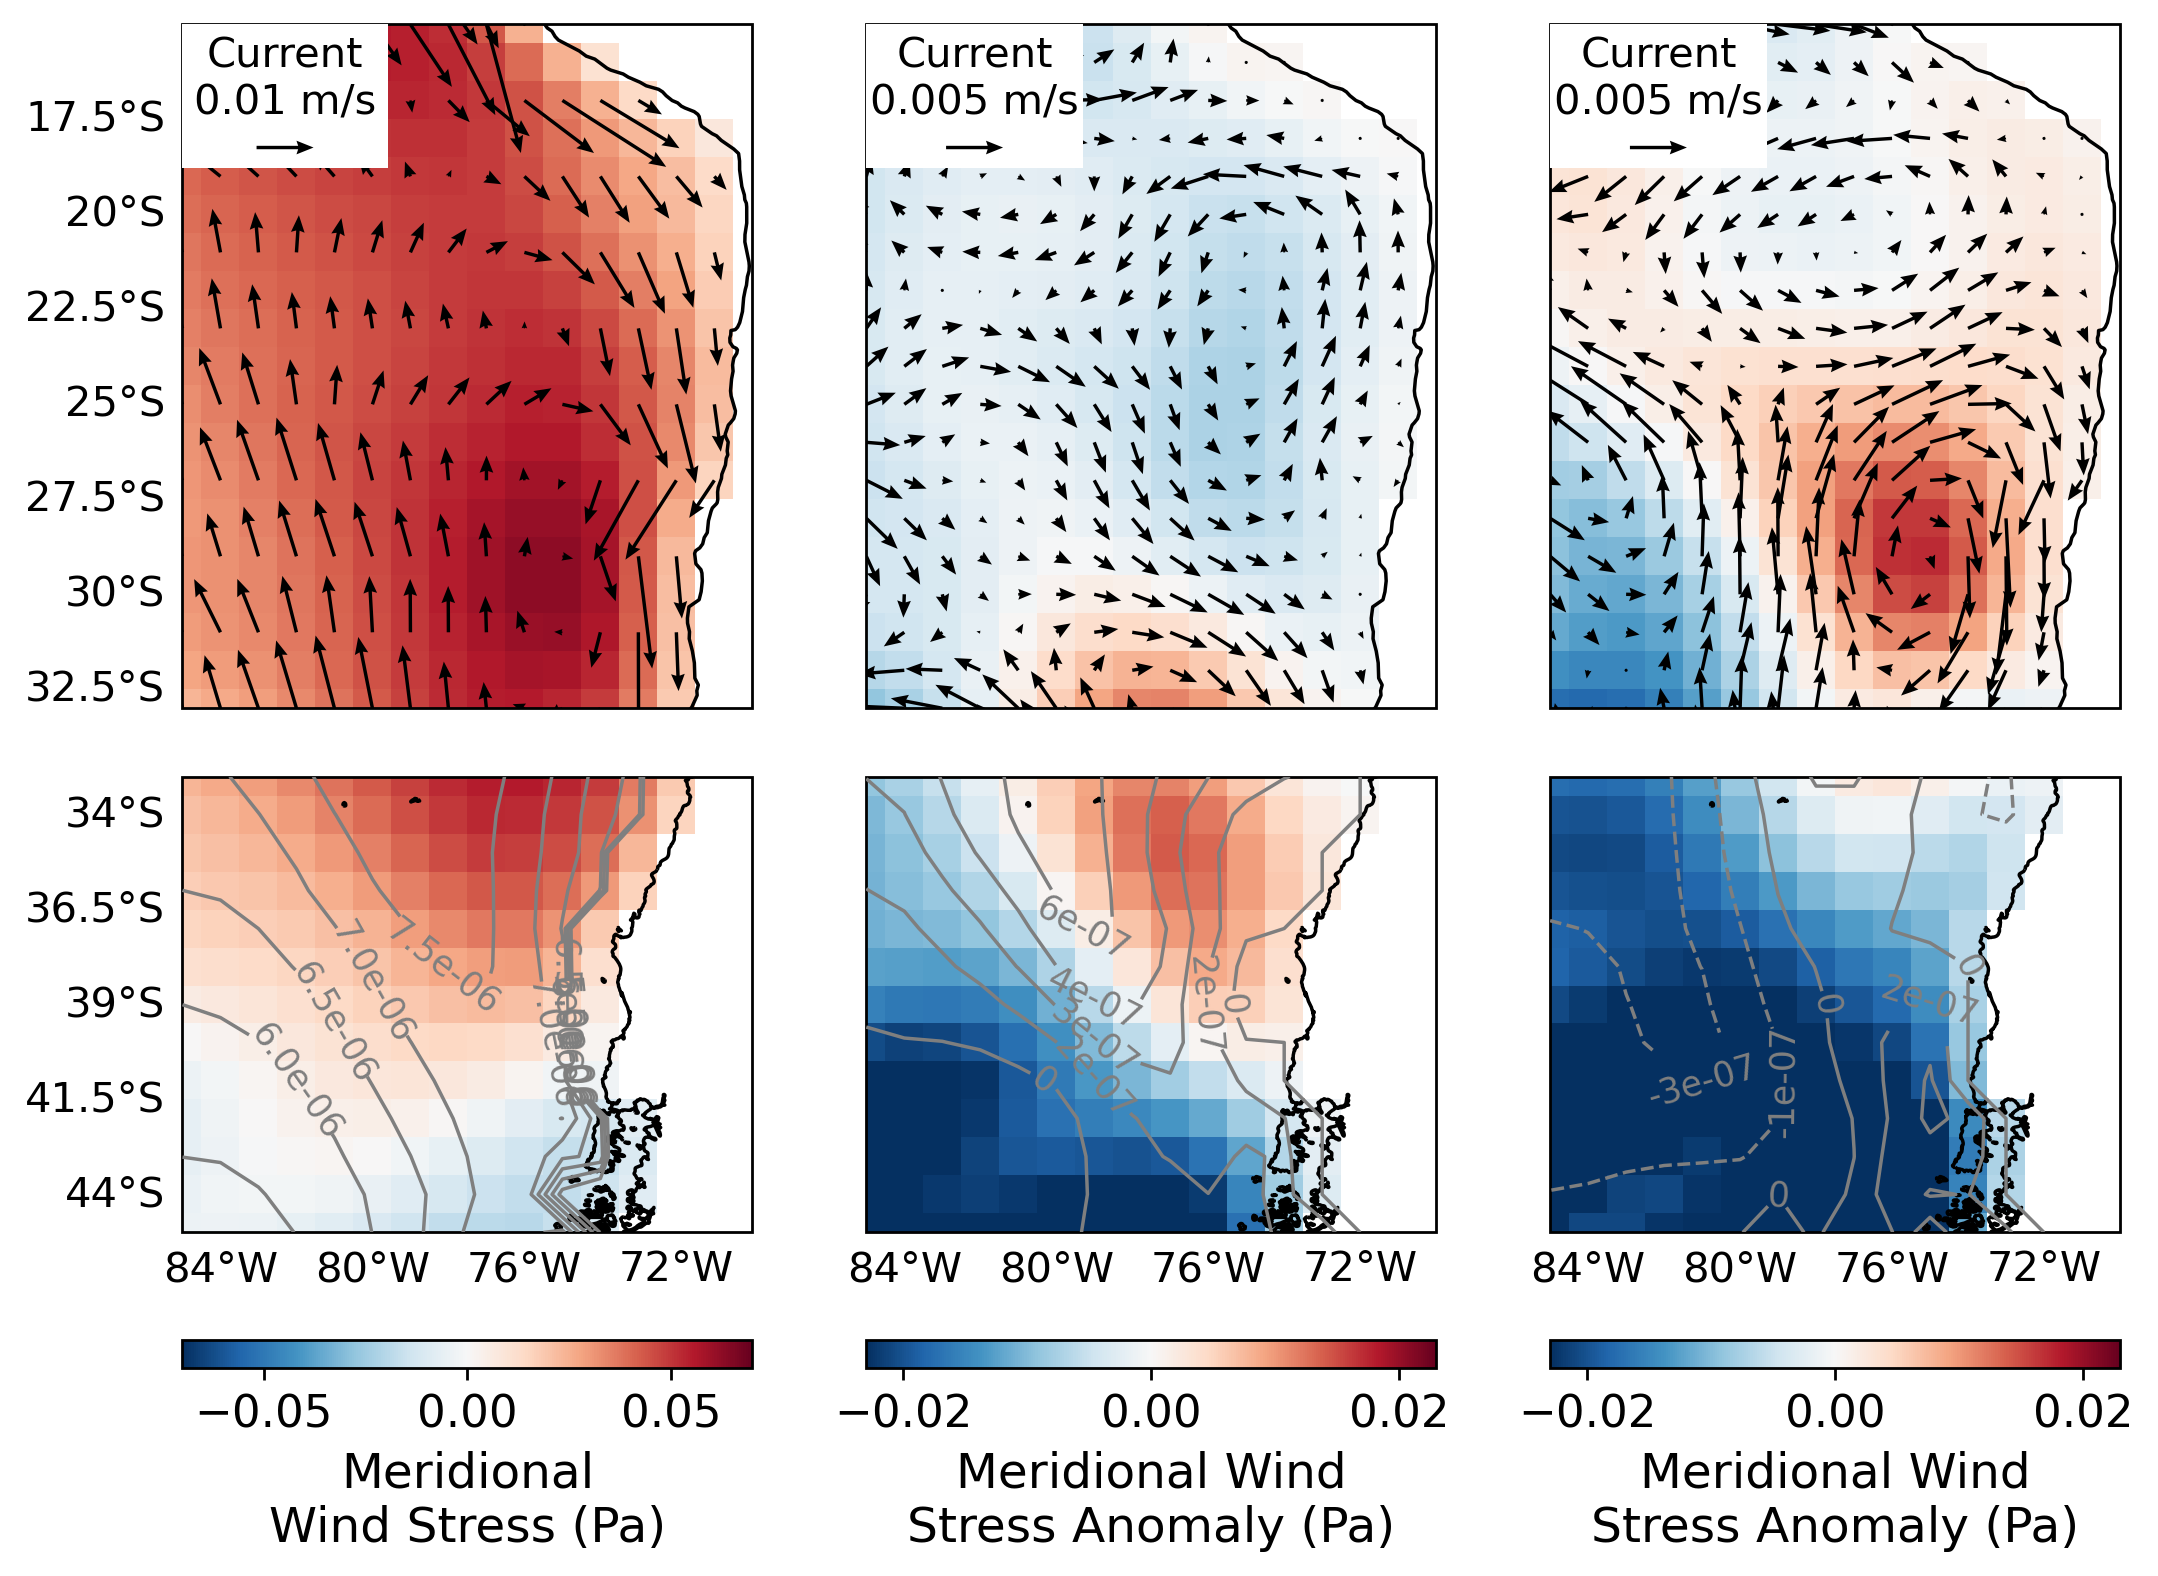

In [41]:
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(2, 3, subplot_kw={'projection':ccrs.PlateCarree()}, dpi=250, figsize=(10,10), 
                       gridspec_kw={'height_ratios': [1, 0.68]})

ax[0,0].set_extent([275, 290, -33, -15])
pc = ax[0,0].pcolormesh(x, y, tauy_full.mean('time'), cmap='RdBu_r', vmin=-0.07, vmax=0.07)

quiv = ax[0,0].quiver(X[skip],Y[skip],uvel_mean_spatial[skip],vvel_mean_spatial[skip], scale=.1, 
                      width=0.006, headwidth=4)
qk = ax[0,0].quiverkey(quiv, 0.18, 0.82, 0.01, 'Current\n0.01 m/s', fontproperties={'size':12})
qk.set_zorder(10)
ax[0,0].add_patch(mpatches.Rectangle(xy=[0, 0.79], width=0.36, height=0.21,
                        facecolor='white',
                        transform=ax[0,0].transAxes, zorder=3)
     )

ax[0,1].set_extent([275, 290, -33, -15])
pc = ax[0,1].pcolormesh(x, y, anomaly_1989, cmap='RdBu_r', vmin=-0.023, vmax=0.023)

quiv = ax[0,1].quiver(x,y,uvel_1989_spatial-uvel_mean_spatial,vvel_1989_spatial-vvel_mean_spatial, scale=.05, 
                      width=0.006, headwidth=4)
qk = ax[0,1].quiverkey(quiv, 0.19, 0.82, 0.005, 'Current\n0.005 m/s', fontproperties={'size':12})
qk.set_zorder(10)
ax[0,1].add_patch(mpatches.Rectangle(xy=[0, 0.79], width=0.38, height=0.21,
                        facecolor='white',
                        transform=ax[0,1].transAxes, zorder=3)
     )

ax[0,2].set_extent([275, 290, -33, -15])
pc = ax[0,2].pcolormesh(x, y, anomaly_2006, cmap='RdBu_r', vmin=-0.023, vmax=0.023)

quiv = ax[0,2].quiver(x,y,uvel_2006_spatial-uvel_mean_spatial,vvel_2006_spatial-vvel_mean_spatial, scale=.05, 
                      width=0.006, headwidth=4)
qk = ax[0,2].quiverkey(quiv, 0.19, 0.82, 0.005, 'Current\n0.005 m/s', fontproperties={'size':12})
qk.set_zorder(10)
ax[0,2].add_patch(mpatches.Rectangle(xy=[0, 0.79], width=0.38, height=0.21,
                        facecolor='white',
                        transform=ax[0,2].transAxes, zorder=3)
     )

ax[1,0].set_extent([275, 290, -45, -33])
pc = ax[1,0].pcolormesh(x, y, tauy_full.mean('time'), cmap='RdBu_r', vmin=-0.07, vmax=0.07)
cbar = plt.colorbar(pc, ax=ax[1,0], orientation='horizontal', pad=0.1)
cbar.set_label('Meridional\nWind Stress (Pa)', fontsize=14)
cbar.ax.tick_params(labelsize=13)

def fmt(x):
    return f'{x:.1e}'
    if 'e' in s:
        base, exp = s.split('e')
        exp = exp.lstrip('0').replace('+', '')  # Remove leading zero and plus sign from exponent
        s = f'{base}e{exp}'
    return s

cp = ax[1,0].contour(DOC_full_spatial.lon, DOC_full_spatial.lat, DOC_full_spatial, zorder=10, colors='tab:gray', 
                levels=np.linspace(5e-6, 8e-6, 7), linewidths=1, alpha=1)
ax[1,0].clabel(cp, fontsize=10, fmt=fmt)

ax[1,1].set_extent([275, 290, -45, -33])
pc = ax[1,1].pcolormesh(x, y, anomaly_1989, cmap='RdBu_r', vmin=-0.023, vmax=0.023)
cbar = plt.colorbar(pc, ax=ax[1,1], orientation='horizontal', pad=0.1)
cbar.set_label('Meridional Wind\nStress Anomaly (Pa)', fontsize=14)
cbar.ax.tick_params(labelsize=13)

cp = ax[1,1].contour(DOC_full_spatial.lon, DOC_full_spatial.lat, DOC_1989_spatial-DOC_full_spatial, zorder=10, 
                colors='tab:gray', linewidths=1, levels=np.linspace(-6e-7,6e-7, 9))
ax[1,1].clabel(cp, fontsize=10, fmt="%.g")

ax[1,2].set_extent([275, 290, -45, -33])
pc = ax[1,2].pcolormesh(x, y, anomaly_2006, cmap='RdBu_r', vmin=-0.023, vmax=0.023)
cbar = plt.colorbar(pc, ax=ax[1,2], orientation='horizontal', pad=0.1)
cbar.set_label('Meridional Wind\nStress Anomaly (Pa)', fontsize=14)
cbar.ax.tick_params(labelsize=13)

cp = ax[1,2].contour(DOC_full_spatial.lon, DOC_full_spatial.lat, DOC_2006_spatial-DOC_full_spatial, zorder=10, 
                colors='tab:gray', linewidths=1, levels=np.linspace(-6e-7,6e-7, 9))
ax[1,2].clabel(cp, fontsize=10, fmt="%.g")

for j, row in enumerate(ax):
    for i, axis in enumerate(row):
        axis.coastlines()
        gl = axis.gridlines(crs=ccrs.PlateCarree(), alpha=0, linewidth=1)
        if j==1: 
            gl.bottom_labels = True
            gl.ylocator = mticker.FixedLocator([-34, -36.5, -39, -41.5, -44])
        if i==0: gl.left_labels=True
        gl.ylabel_style = {'size': 12}
        gl.xlabel_style = {'size': 12}
        
        
plt.subplots_adjust(hspace=-0.55)

